In [1]:
# Load all features and labels
import numpy as np
x_altp = np.load('x_altp_L_5.npy')
x_wsn = np.load('x_wsn_8_1_J_10_new_T.npy')
x_mfcc = np.load('x_mfcc.npy')

y = np.load('y.npy')

In [17]:
print(x_wsn.shape)

(12704, 373)


In [16]:
# SPLIT INTO TRAIN AND TEST SETS ( train set will be used for cross validation and train set for evaluation of final model performance )

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x = np.hstack([x_altp])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
np.where(y_test==-1)[0].shape

(2843,)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#%seaborn qt
%matplotlib qt

x_graph = x_test
pos_idx = np.where(y_test==1)
neg_idx = np.where(y_test==-1)
width=0.3
a = {}
a['abnormal'] = np.sum(x_graph[pos_idx], axis=0)/len(pos_idx[0])
a['normal'] = np.sum(x_graph[neg_idx], axis=0)/len(neg_idx[0])
a['diff'] = abs(a['abnormal'] - a['normal'])
a['x'] = np.arange(x_graph.shape[1])
plt.bar(np.arange(x_graph.shape[1]),np.sum(x_graph[pos_idx], axis=0)/len(pos_idx[0]), width=width, label='abnormal')
plt.bar(np.arange(x_graph.shape[1])+width,np.sum(x_graph[neg_idx], axis=0)/len(neg_idx[0]), width=width, label='normal')
plt.bar(np.arange(x_graph.shape[1])+2*width,abs(np.sum(x_graph[pos_idx], axis=0)/len(pos_idx[0])-np.sum(x_graph[neg_idx], axis=0)/len(neg_idx[0])), width=width, label='|diff|')
plt.legend(loc="upper right")
plt.show()

In [17]:
# Holdout test scoring of the best performing classifiers from cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.svm  import SVC
models = {
    'KNN1' : KNeighborsClassifier(n_neighbors=1, weights='distance', p=1).fit(x_train, y_train),
    'KNN3' : KNeighborsClassifier(n_neighbors=3, weights='distance', p=1).fit(x_train, y_train),
    'KNN5' : KNeighborsClassifier(n_neighbors=5, weights='distance', p=1).fit(x_train, y_train),
    'KNN7' : KNeighborsClassifier(n_neighbors=7, weights='distance', p=1).fit(x_train, y_train),
    'KNN9' : KNeighborsClassifier(n_neighbors=1, weights='distance', p=1).fit(x_train, y_train),
    'SVM3-RBF' : SVC(kernel='rbf', probability=True, random_state=0).fit(x_train, y_train)
}


for model_key, model in models.items():
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
    print (f'Acurracy for modeld {model_key}', model.score(x_test, y_test))
    print(f'Sensitivity for model {model_key}', tp/(tp+fn))
    print(f'Specificity for model {model_key}', tn/(tn+fp))
    print(f'AUC score for model {model_key}', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))

Acurracy for modeld KNN1 0.8730325288562435
Sensitivity for model KNN1 0.7337461300309598
Specificity for model KNN1 0.9205065072106929
AUC score for model KNN1 0.8271263186208263
Acurracy for modeld KNN3 0.8869359916054564
Sensitivity for model KNN3 0.7574819401444789
Specificity for model KNN3 0.9310587407667956
AUC score for model KNN3 0.9151677739796513
Acurracy for modeld KNN5 0.8845750262329486
Sensitivity for model KNN5 0.7420020639834881
Specificity for model KNN5 0.9331691874780161
AUC score for model KNN5 0.9362691556434485
Acurracy for modeld KNN7 0.8861490031479539
Sensitivity for model KNN7 0.7492260061919505
Specificity for model KNN7 0.9328174463594794
AUC score for model KNN7 0.9438225148437291
Acurracy for modeld KNN9 0.8730325288562435
Sensitivity for model KNN9 0.7337461300309598
Specificity for model KNN9 0.9205065072106929
AUC score for model KNN9 0.8271263186208263
Acurracy for modeld SVM3-RBF 0.8911332633788038
Sensitivity for model SVM3-RBF 0.7203302373581011
Sp

In [5]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, KNN1.predict(x_test)))

[[2617  226]
 [ 258  711]]


In [4]:
# Results
print(KNN1_pred, KNN3_pred, KNN5_pred, KNN7_pred, KNN9_pred, SVM_pred)

0.8730325288562435 0.8869359916054564 0.8845750262329486 0.8861490031479539 0.8840503672612802 0.8911332633788038


10 fold accuracy with training set shape (8892, 32) for KNN7-MAN is 0.8740425424350045 
sensitivity:  0.7976536679417503
specificity:  0.9073819408048369
AUC:  0.9440778964650459
confusion matrix:  [[5623  574]
 [ 546 2149]]


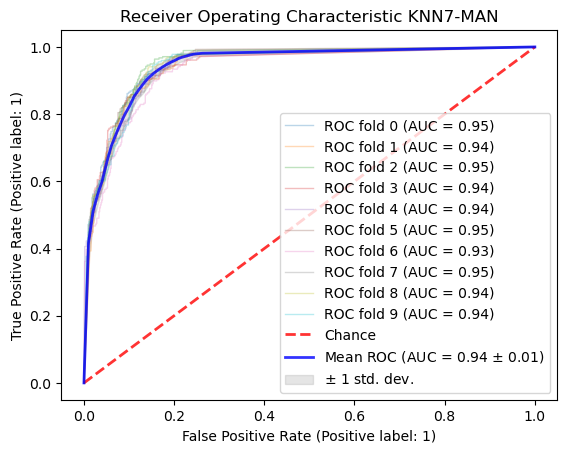

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## CLASSIFICATION
# Run classifier with cross-validation and plot ROC curves
k = 10
cv = KFold(n_splits=k, shuffle = True, random_state=0)
classifiers = {}
#classifiers['SVM-RBF'] = SVC(probability=True, random_state=0)
#classifiers['KNN1-MAN'] = KNeighborsClassifier(n_neighbors=1, weights='distance', p=1)
#classifiers['KNN3-MAN'] = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)
#classifiers['KNN5-MAN'] = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
classifiers['KNN7-MAN'] = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1)
#classifiers['KNN9-MAN'] = KNeighborsClassifier(n_neighbors=9, weights='distance', p=1)
#classifiers['KNN11-MAN'] = KNeighborsClassifier(n_neighbors=11, weights='distance', p=1)
#classifiers['KNN21-MAN'] = KNeighborsClassifier(n_neighbors=21, weights='distance', p=1)
#classifiers['RF'] = RandomForestClassifier()

for key, classifier in classifiers.items(): 
  accs = []
  spec = []
  sens = []
  tprs = []
  aucs = []
  confusion = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(x_train, y_train)):
    classifier.fit(x[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
        pos_label=1,
        response_method='predict_proba'
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    accs.append(classifier.score(x[test],y[test]))
    confusion_m = confusion_matrix(y[test], classifier.predict(x[test]))
    confusion.append(confusion_m)
    tn, fp, fn, tp = confusion_m.ravel()
    specificity = tn / (tn+fp)
    spec.append(tn / (tn+fp))
    sens.append(tp / (tp+fn))

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic "+key,
  )
  ax.legend(loc="lower right")
  plt.savefig("crossval_altp_{}.pdf".format(key))

  print('{} fold accuracy with training set shape {} for {} is {} '.format(\
    k, x_train.shape, key, np.mean(accs)))
  print('sensitivity: ', np.mean(sens))
  print('specificity: ', np.mean(spec))
  print('AUC: ', np.mean(aucs))
  print('confusion matrix: ', np.sum(confusion, axis=0))